In [1]:
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images,  train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data,train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=2, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'exp_42/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name)

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jack_Y6/Cutouts/'
hdu_list = fits.open(path_cutouts + 'Jack_Y6.fits')
lenses = hdu_list[1].data 
data_pos = hdu_list[2].data[:]
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
hdu_list.close()

# Negative cases
num_neg = 2
path_neg = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/negative_redmagic.fits'
hdu_list = fits.open(path_neg)
ind = random.sample(range(len(hdu_list[1].data)), num_neg)
negatives = hdu_list[1].data[ind,:] 
negatives = negatives[:,0:3,:,:]
data_neg = pd.DataFrame(columns=data_pos.columns)
my_list = [0]*num_neg
for column in data_pos.columns:
    data_neg[column] = my_list
hdu_list.close()

images = np.concatenate((lenses, negatives)).astype(np.float32)
data = pd.concat((data_pos, data_neg))
labels_lenses, labels_negatives = np.zeros(len(lenses), dtype = np.int64), np.ones(len(negatives), dtype = np.int64)
labels = np.concatenate((labels_lenses, labels_negatives))

train_dataset, test_dataset = make_train_test_datasets(images, data, labels, test_size=0.99, transform=transform)
print(len(train_dataset), len(test_dataset))
print(sum(test_dataset.labels==0))
print(sum(test_dataset.labels==1))

2 246
244
2


In [8]:
search_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
prob_lim = 0.5

In [9]:
right_positives, wrong_positives = np.zeros((1, 3, 45, 45)), np.zeros((1, 3, 45, 45))
right_negatives, wrong_negatives = np.zeros((1, 3, 45, 45)), np.zeros((1, 3, 45, 45))
right_data, wrong_data = pd.DataFrame(columns=data_pos.columns), pd.DataFrame(columns=data_pos.columns)
prob_list = []
for i_batch, sample in enumerate(tqdm(search_loader)):
    #if(i_batch==10): break
    
    sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
    output = model(sample_image)
    predicted = output.argmax(dim=1).item()
    
    prob = nn.Softmax(dim=1)(output)
    prob = prob[:,0].detach().numpy()[0]
    prob_list.append(prob)
    
    predicted = 0 if prob >= prob_lim else 1
    
    if(predicted == 0 and sample_label.item() == 0):
        right_positives = np.append(right_positives, [np.array(sample_img[0])], axis = 0)
        sample_data['Prob'] = prob
        data_point = pd.DataFrame.from_dict(sample_data)
        right_data = right_data.append(data_point)
    elif(predicted == 1 and sample_label.item() == 0):
        wrong_positives = np.append(wrong_positives, [np.array(sample_img[0])], axis = 0)
        sample_data['Prob'] = prob
        data_point = pd.DataFrame.from_dict(sample_data)
        wrong_data = wrong_data.append(data_point)
    elif(predicted == 1 and sample_label.item() == 1):
        right_negatives = np.append(right_negatives, [np.array(sample_img[0])], axis = 0)
    elif(predicted == 0 and sample_label.item() == 1):
        wrong_negatives = np.append(wrong_negatives, [np.array(sample_img[0])], axis = 0)

right_positives = np.delete(right_positives, 0, axis = 0)
wrong_positives = np.delete(wrong_positives, 0, axis = 0)
right_negatives = np.delete(right_negatives, 0, axis = 0)
wrong_negatives = np.delete(wrong_negatives, 0, axis = 0)

wrong_data = wrong_data.reset_index(drop=True)
right_data = right_data.reset_index(drop=True)

  0%|          | 0/246 [00:00<?, ?it/s]

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [10]:
#Threshold of probability: 0.5
print('Total: ' + str(len(wrong_positives) + len(right_positives)))
print('Identified: ' + str(len(right_positives)))
print('Not identified: ' + str(len(wrong_positives)))
print(' ')

print('Not identified lenses with Einstein radius > 6: ' + str(len(wrong_data[wrong_data['einstein_radius'] > 6])))
print('Identified lenses with Einstein radius < 6: ' + str(len(right_data[right_data['einstein_radius'] <= 6])))
print(' ')

ind = right_data[right_data['Prob'] > 0.949].index
print('Right positives with a 0.949 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.974].index
print('Right positives with a 0.974 threshold: '+ str(len(ind)))

Total: 244
Identified: 115
Not identified: 129
 
Not identified lenses with Einstein radius > 6: 103
Identified lenses with Einstein radius < 6: 100
 
Right positives with a 0.949 threshold: 88
Right positives with a 0.974 threshold: 79


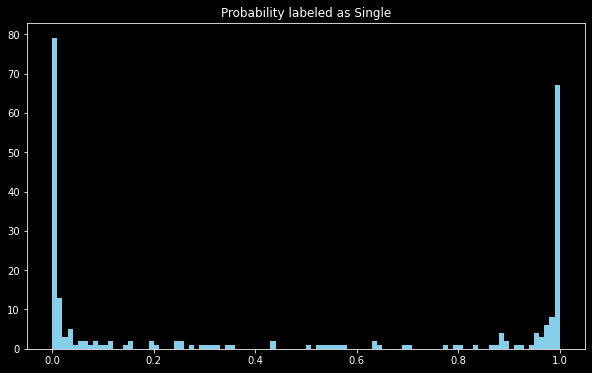

In [11]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [12]:
def make_plot_all(objects, data):
    
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                title = '{:.3f}'.format(data['DNF_ZMEAN_SOF'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Wrong lenses with E < 6


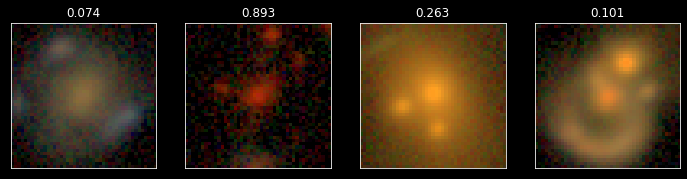

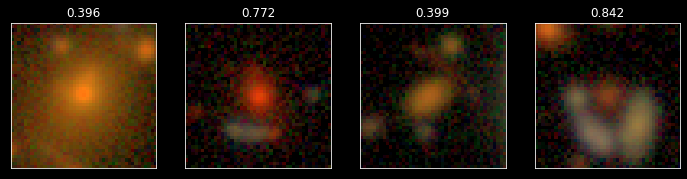

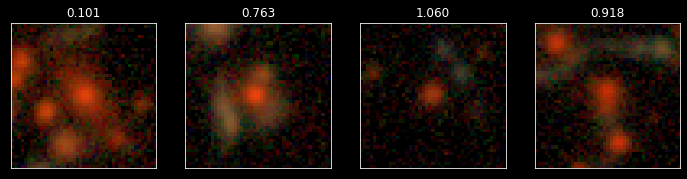

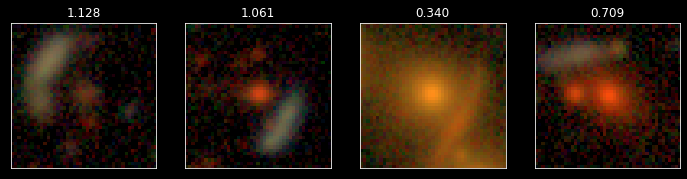

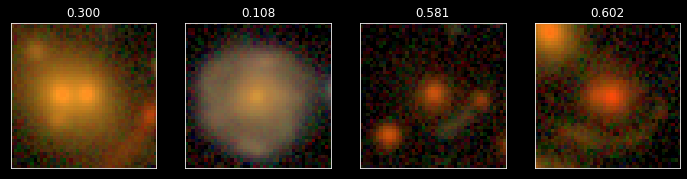

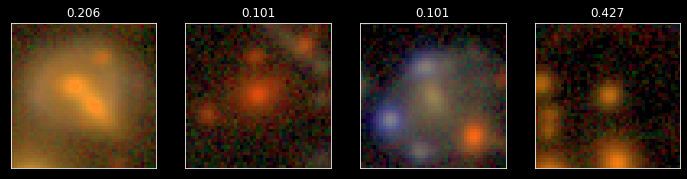

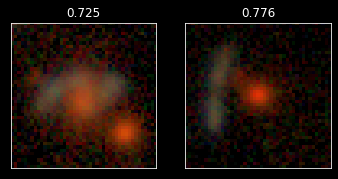

In [13]:
print('Wrong lenses with E < 6')
ind = wrong_data[wrong_data['einstein_radius'] < 6].index
objects = wrong_positives[ind]
make_plot_all(objects, wrong_data.loc[ind])

Right lenses with E < 6


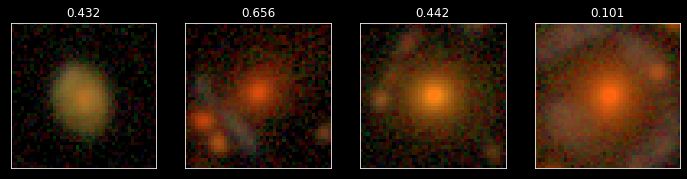

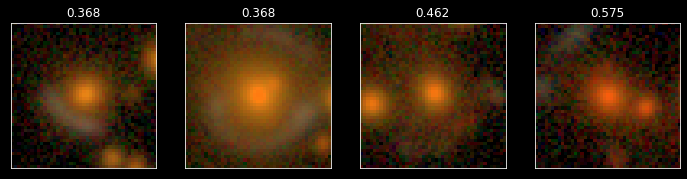

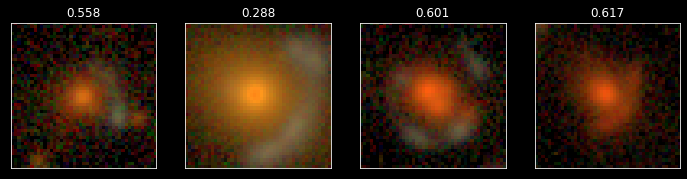

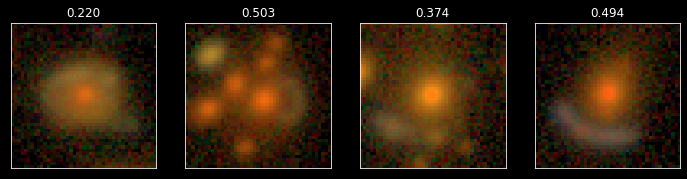

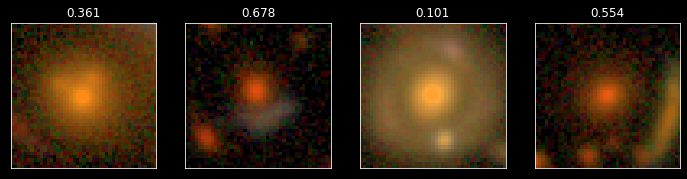

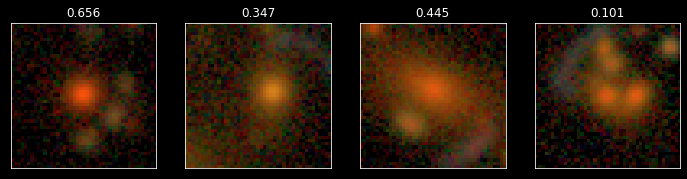

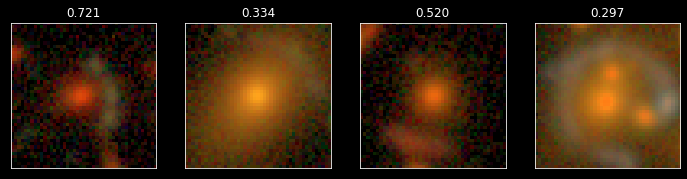

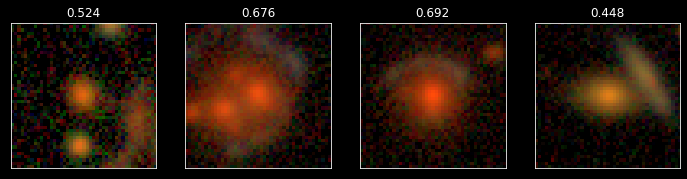

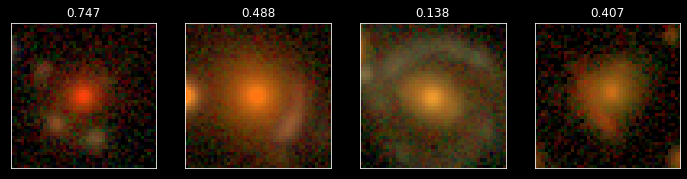

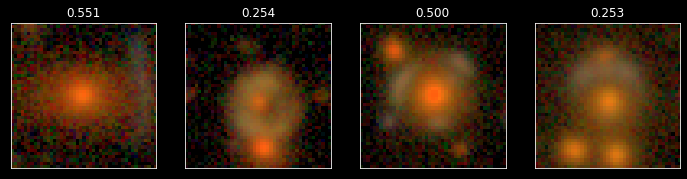

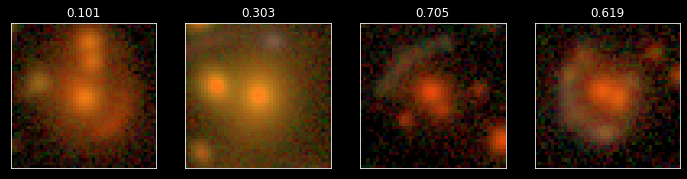

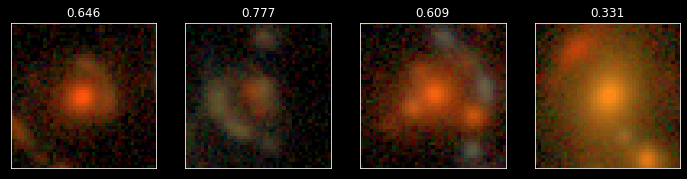

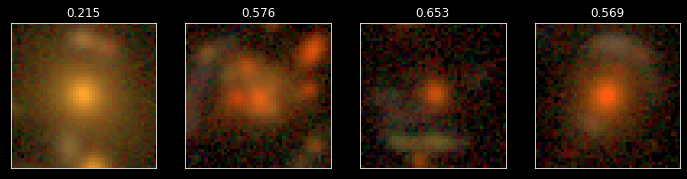

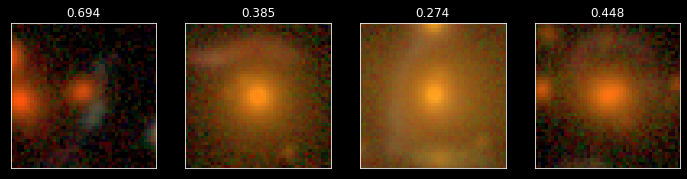

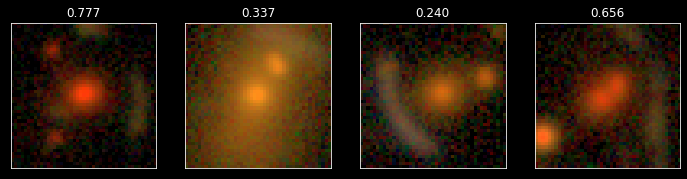

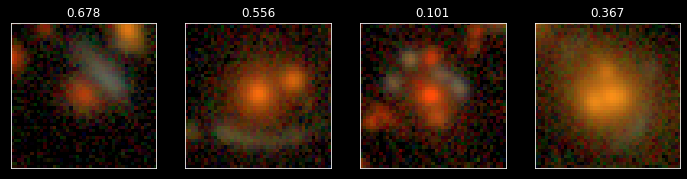

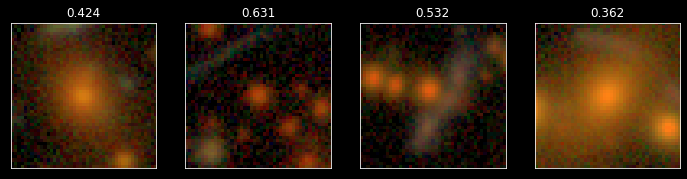

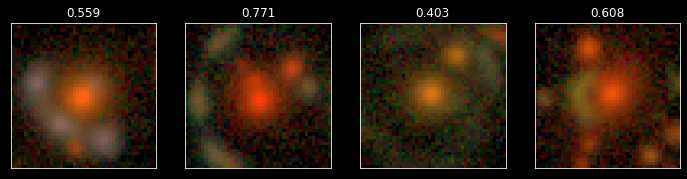

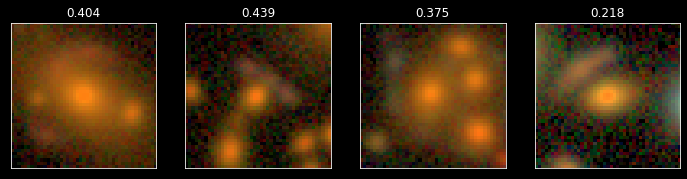

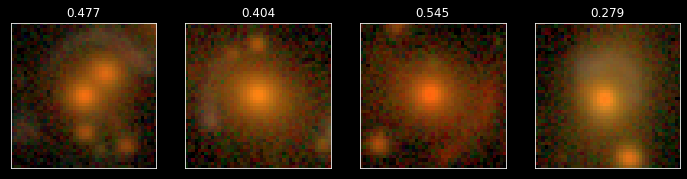

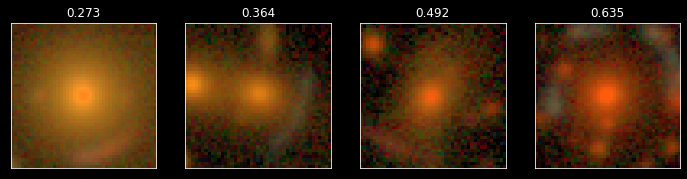

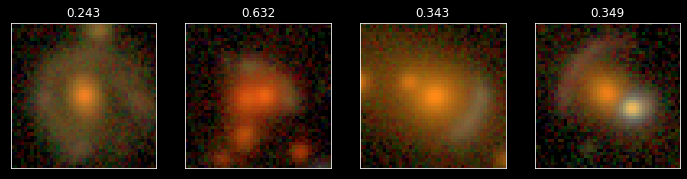

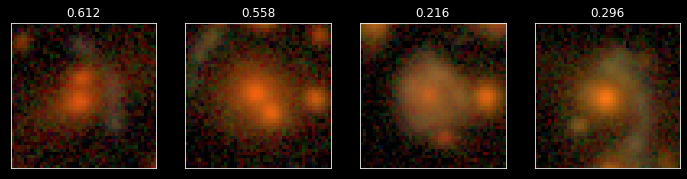

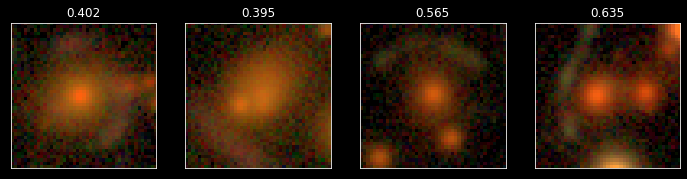

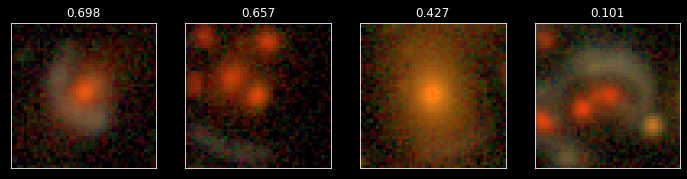

In [14]:
print('Right lenses with E < 6')
ind = right_data[right_data['einstein_radius'] < 6].index
objects = right_positives[ind]
make_plot_all(objects, right_data.loc[ind])

Wrong lenses with E > 6


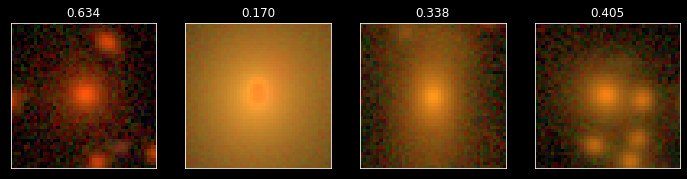

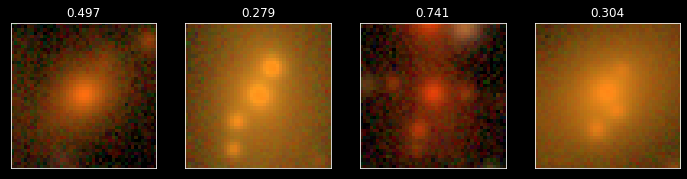

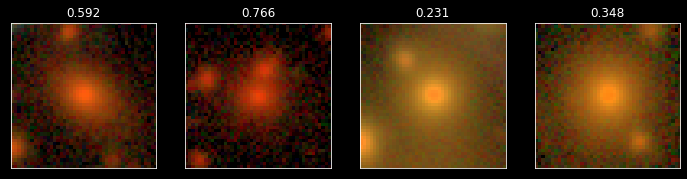

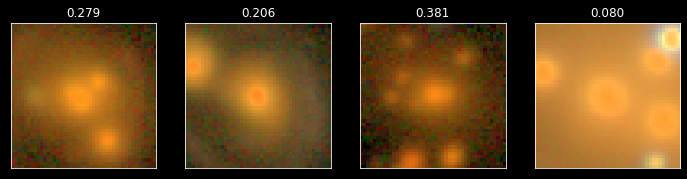

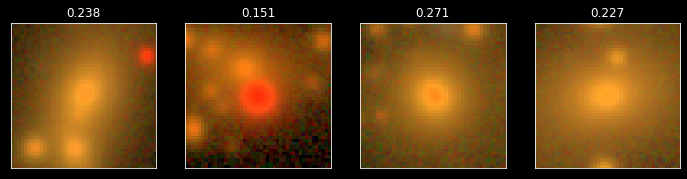

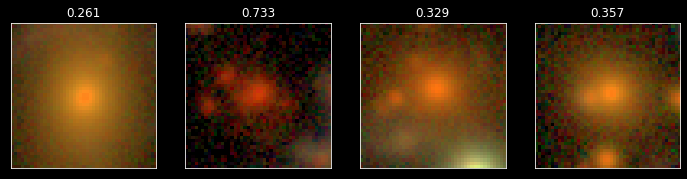

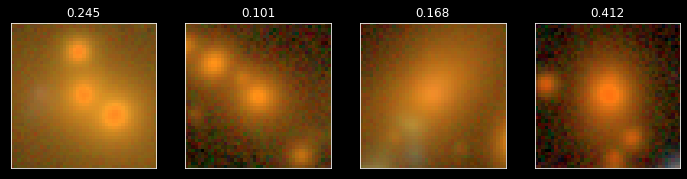

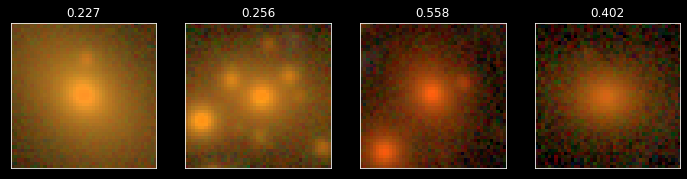

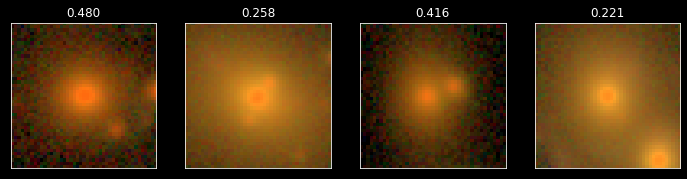

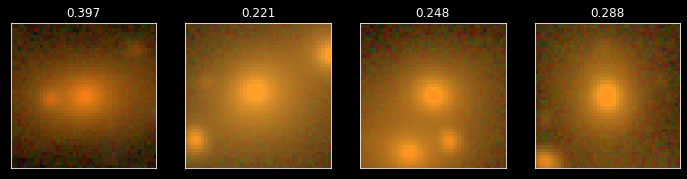

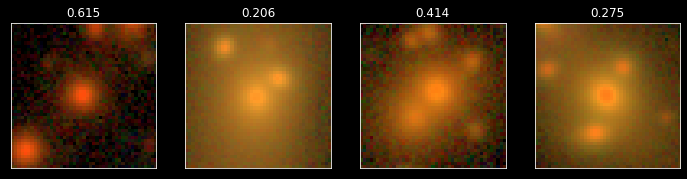

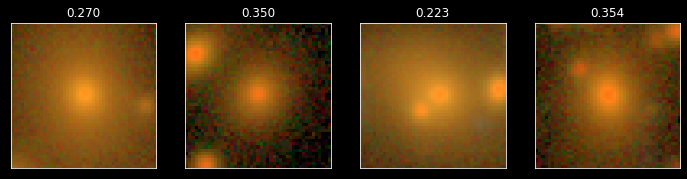

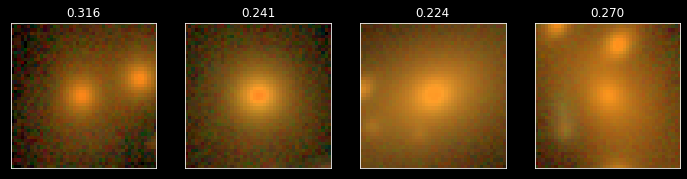

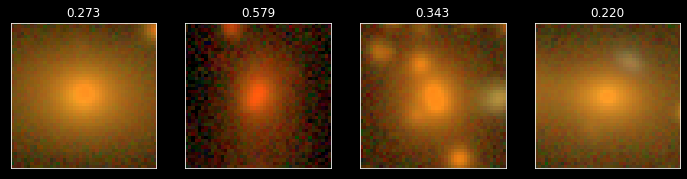

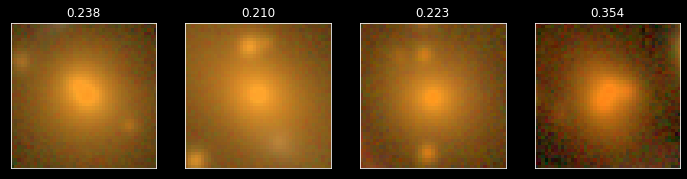

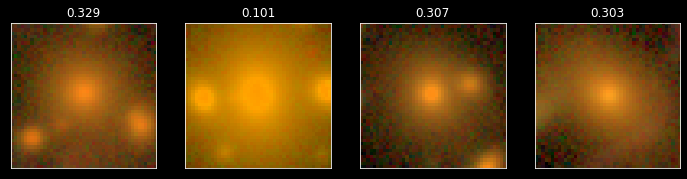

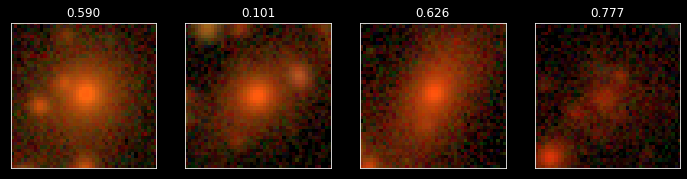

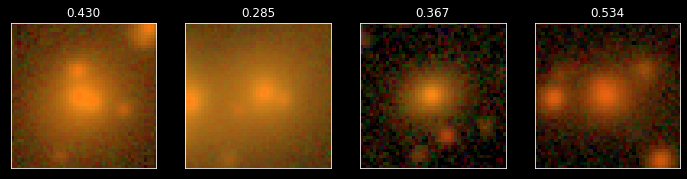

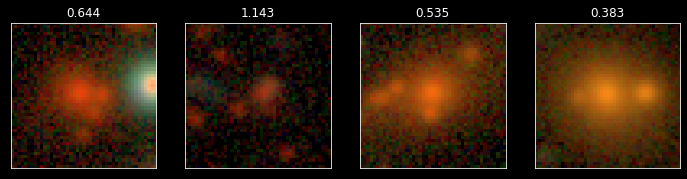

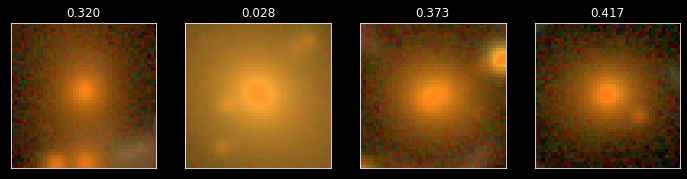

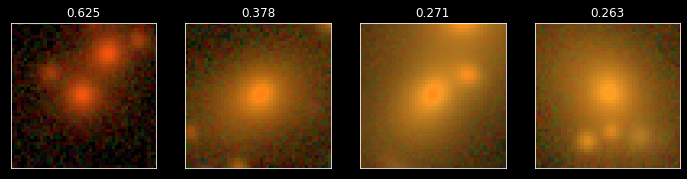

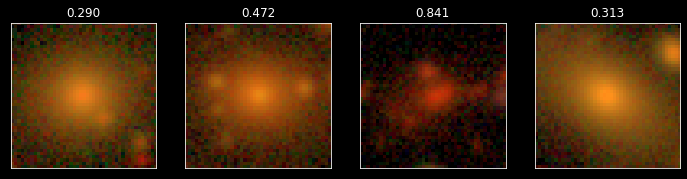

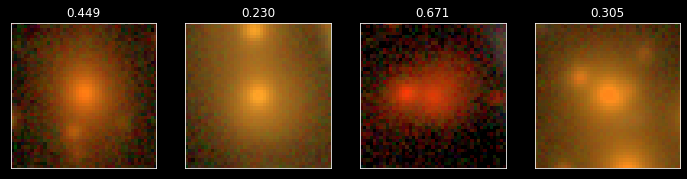

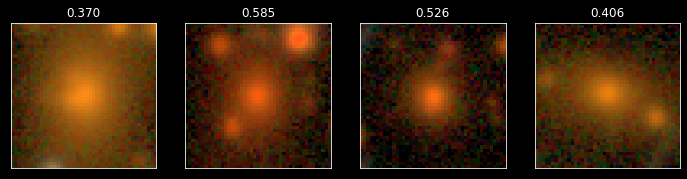

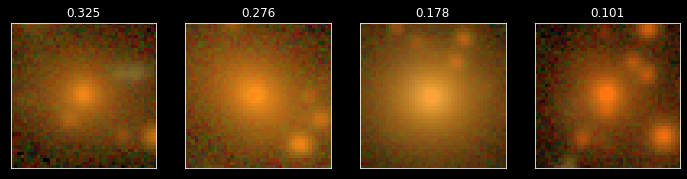

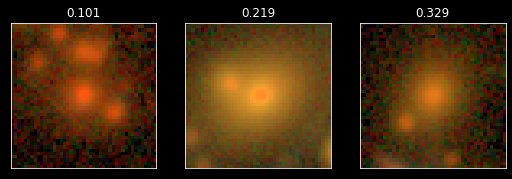

In [15]:
print('Wrong lenses with E > 6')
ind = wrong_data[wrong_data['einstein_radius'] > 6].index
objects = wrong_positives[ind]
make_plot_all(objects, wrong_data.loc[ind])

Right lenses with E > 6


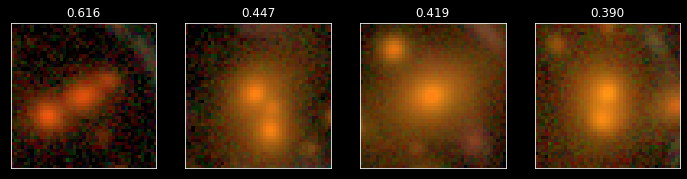

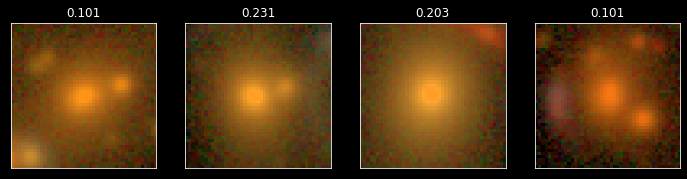

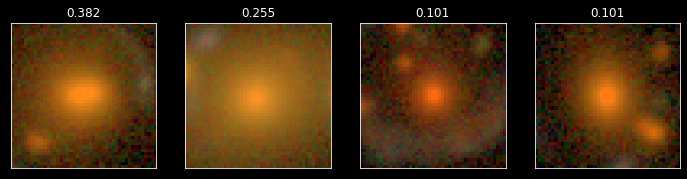

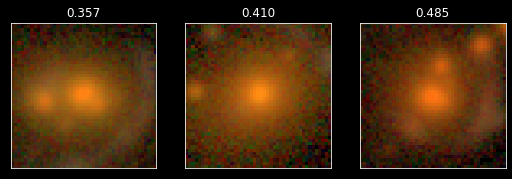

In [16]:
print('Right lenses with E > 6')
ind = right_data[right_data['einstein_radius'] > 6].index
objects = right_positives[ind]
make_plot_all(objects, right_data.loc[ind])

In [17]:
names = ['name', 'ra', 'dec', 'comment', 'rank', 'num_sources', 'num_lenses', 'mem_match_id',
        'einstein_radius', 'einstein_radius_err', 'ACT', 'BBNA', 'BNA', 'TI', 'RNA', 'RNA2', 'redM', 'redM_missed',
        'SPTPol', 'algo', 'D17', 'J1', 'J2', 'aliases', 'Prob']
print(len(names))

25


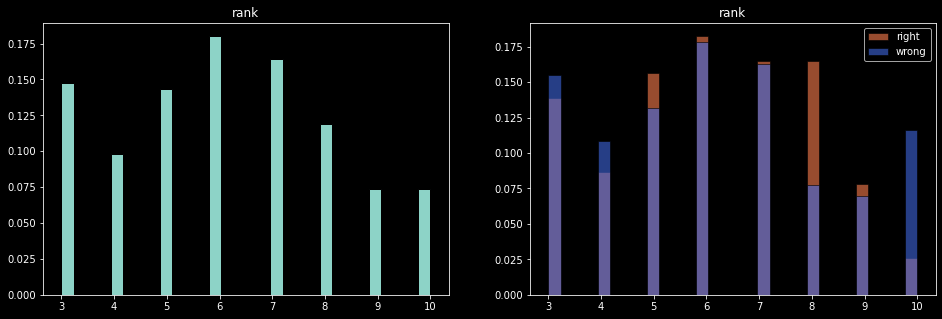

In [18]:
i=4

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(names[i])
data_all = np.concatenate((right_data[names[i]], wrong_data[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(names[i])
weights = np.ones_like(right_data[names[i]]) / len(right_data['rank'])
plt.hist(right_data[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_data[names[i]]) / len(wrong_data['rank'])
plt.hist(wrong_data[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()

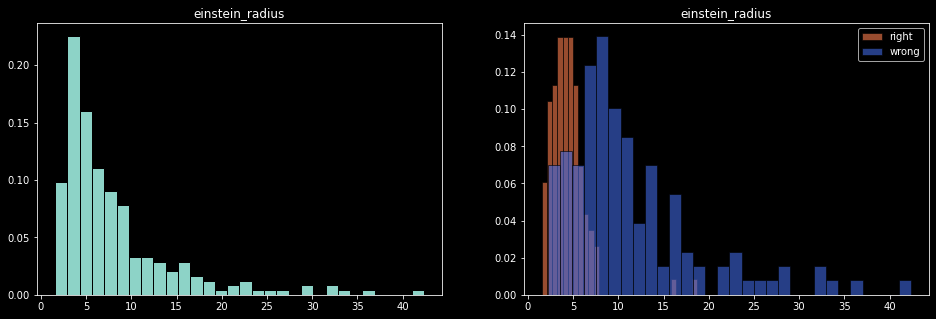

In [19]:
i=8

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(names[i])
data_all = np.concatenate((right_data[names[i]], wrong_data[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(names[i])
weights = np.ones_like(right_data[names[i]]) / len(right_data['rank'])
plt.hist(right_data[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_data[names[i]]) / len(wrong_data['rank'])
plt.hist(wrong_data[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()

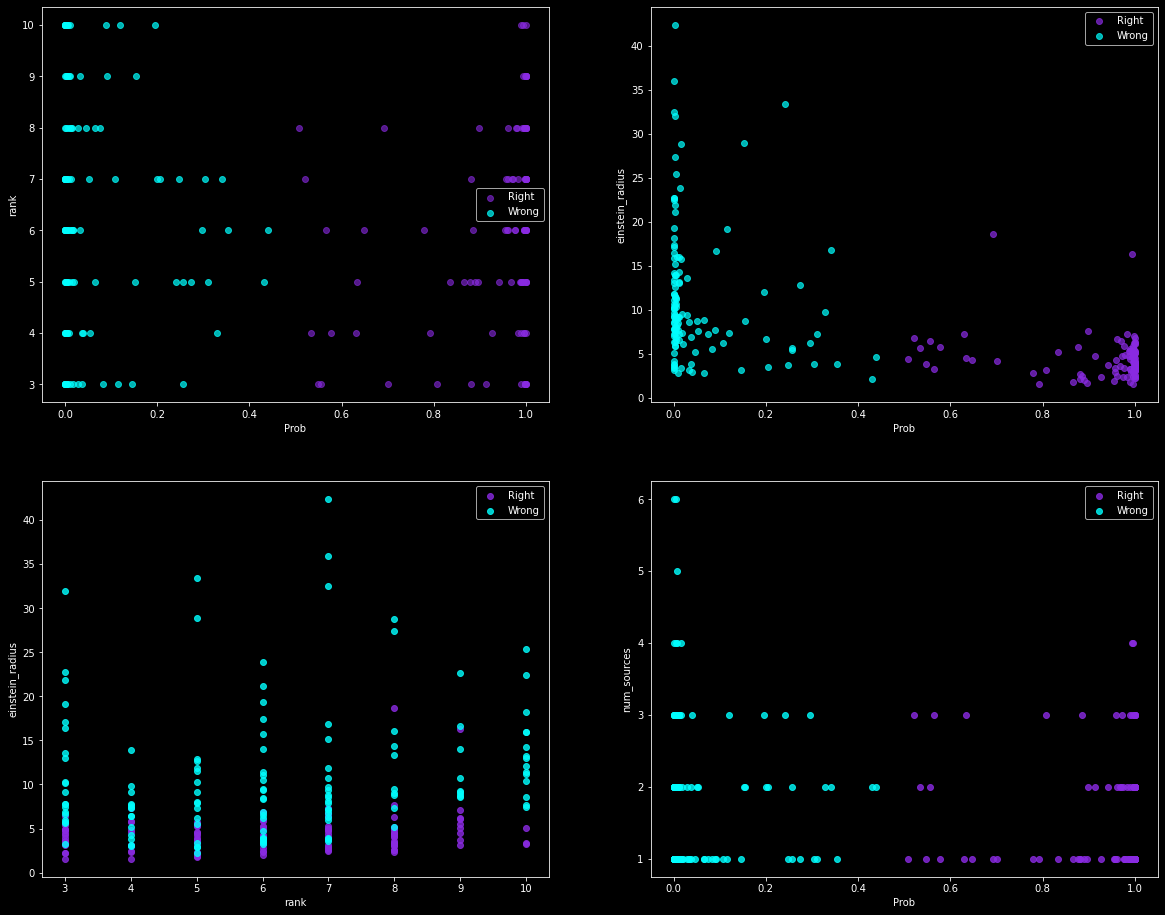

In [20]:
plt.figure(figsize=(20,16)) 

plt.subplot(2,2,1)
plt.xlabel(names[24])
plt.ylabel(names[4])
plt.scatter(right_data[names[24]], right_data[names[4]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[24]], wrong_data[names[4]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(names[24])
plt.ylabel(names[8])
plt.scatter(right_data[names[24]], right_data[names[8]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[24]], wrong_data[names[8]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(names[4])
plt.ylabel(names[8])
plt.scatter(right_data[names[4]], right_data[names[8]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[8]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(2,2,4)
plt.xlabel(names[24])
plt.ylabel(names[5])
plt.scatter(right_data[names[24]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[24]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.show()

In [21]:
print(len(wrong_data)+len(right_data))

wrong_smaller = wrong_data[wrong_data['einstein_radius'] <= 6]
wrong_larger = wrong_data[wrong_data['einstein_radius'] > 6]
right_smaller = right_data[right_data['einstein_radius'] <= 6]
right_larger = right_data[right_data['einstein_radius'] > 6]

print(len(wrong_data), len(wrong_smaller), len(wrong_larger))
print(len(right_data), len(right_smaller), len(right_larger))

244
129 26 103
115 100 15


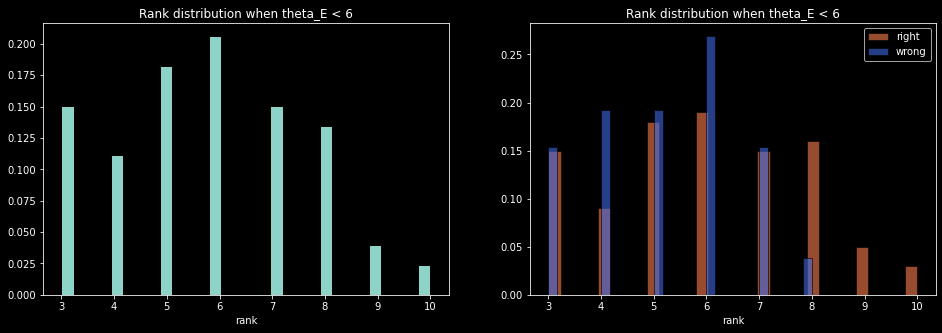

In [22]:
i=4

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
data_all = np.concatenate((right_smaller[names[i]], wrong_smaller[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
weights = np.ones_like(right_smaller[names[i]]) / len(right_smaller[names[i]])
plt.hist(right_smaller[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_smaller[names[i]]) / len(wrong_smaller[names[i]])
plt.hist(wrong_smaller[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()

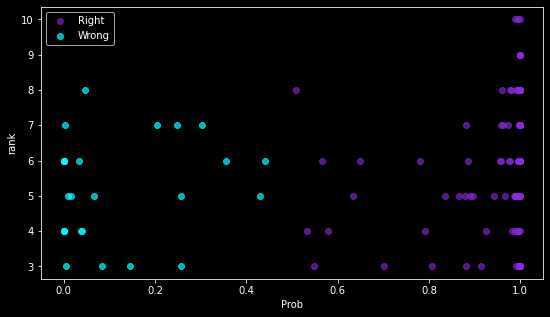

In [23]:
plt.figure(figsize=(9,5))
plt.xlabel(names[24])
plt.ylabel(names[4])
plt.scatter(right_smaller[names[24]], right_smaller[names[4]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_smaller[names[24]], wrong_smaller[names[4]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()
plt.show()